## Training a pricing model

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

In [409]:
data = pd.read_csv('data/pricing_df.csv')
data.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
2,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
3,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
4,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,131


In [410]:
features_list = list(data.columns[:-1])
target_variable = 'rental_price_per_day'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

In [411]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [412]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['mileage', 'engine_power']
Found categorical features  ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


In [413]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#### Regression baseline

In [414]:
linear = LinearRegression()
linear.fit(X_train, Y_train)

train_pred = linear.predict(X_train)
test_pred = linear.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.7156711732458418
f1-score on test set :  0.7117892771783902


What contributes to fitting our model ? (displaying absolute values, so no difference is being made between positive or negative contributions)

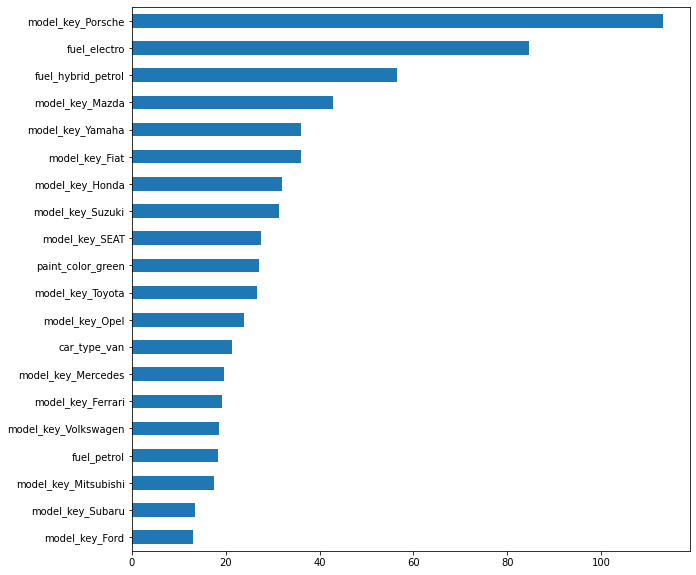

In [211]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(np.abs(linear.coef_), index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show() 

What really matters for predictions ?

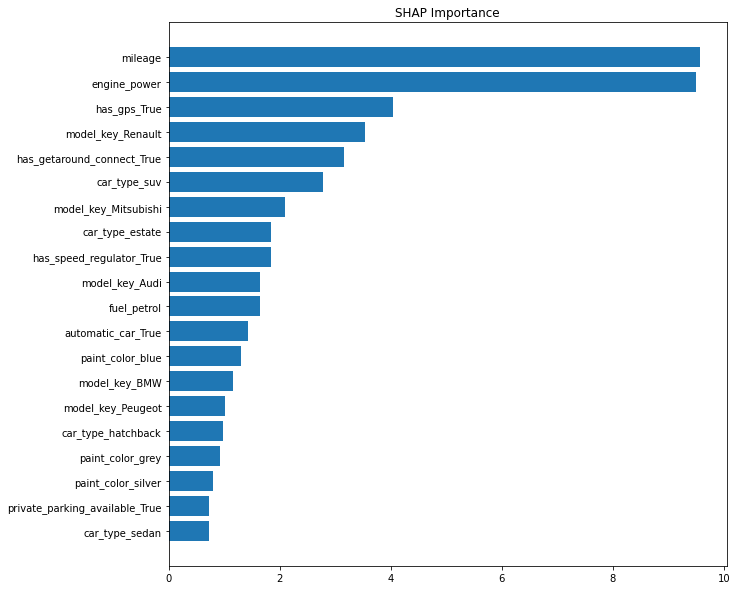

In [242]:
explainer = shap.explainers.Linear(linear, X_train)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
fig = plt.figure(figsize=(10, 10))
plt.barh(range(20), shap_importance[sorted_idx][-20:]) # only top 20 features
plt.yticks(range(20), np.array(col_names)[sorted_idx][-20:]) 
plt.title('SHAP Importance')
plt.show()

SHAP values estimate the impact of a feature on predictions whereas feature importances from coefficient give the impact of a feature on model fit.

Porsche models, electric & hybrid cars have a high coefficient (not surprising) but mileage and engine power matter most for predictions.

#### Gradient Boost Regressor

In [163]:
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor()
params = {
    'learning_rate': [0.1,0.05,0.2],
    'max_leaf_nodes': [20,30,40,50,60],
    'max_depth' : [6,8,10,12,16],
    'min_samples_leaf' : [2,4,6,8,10],
    'n_estimators' : [75,100,125,150]
}

gridsearch = GridSearchCV(gbr, param_grid = params, n_jobs=-1, cv = 7,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.772961 using {'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 30, 'min_samples_leaf': 4, 'n_estimators': 150}


In [176]:
gbr = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 8, max_leaf_nodes= 30, min_samples_leaf= 4, n_estimators= 200)
gbr.fit(X_train, Y_train)

train_pred = gbr.predict(X_train)
test_pred = gbr.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.9181001297794179
f1-score on test set :  0.7844909442938446


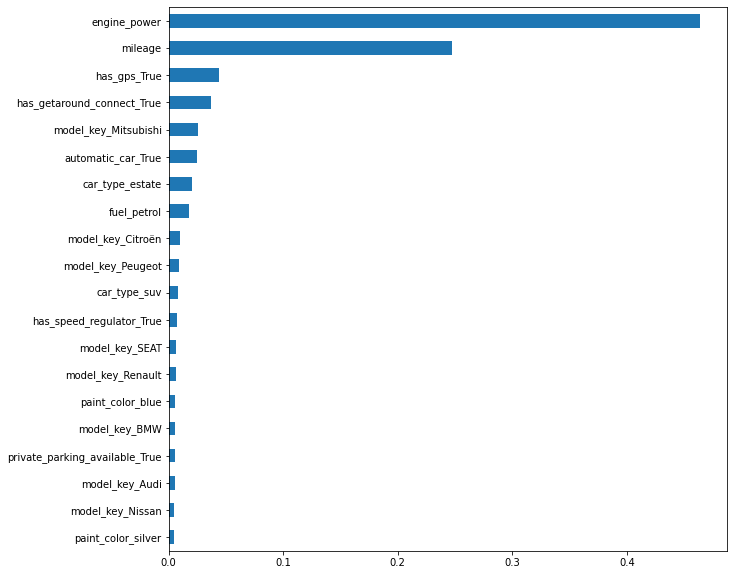

In [212]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(gbr.feature_importances_, index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show()

Our Gradient Boost Regressor model with better results relies more on engine power than mileage.

### Preparing the API

In [428]:
joblib.dump(gbr,'api/gbr_model.pkl')
joblib.dump(preprocessor,'api/preprocessor.pkl')

['api/preprocessor.pkl']

Testing with example input

In [463]:
example_input = {
  "model_key": "Toyota","mileage": 25000,"engine_power": 130,"fuel": "diesel","paint_color": "red","car_type": "sedan","private_parking_available": True,
  "has_gps": True,"has_air_conditioning": True,"automatic_car": False,"has_getaround_connect": True,"has_speed_regulator": True,"winter_tires": True
  }

In [464]:
input_df = pd.DataFrame(columns=list(example_input.keys()))
input_df.loc[0] = list(example_input.values())

In [465]:
X = input_df
X = preprocessor.transform(X)
pred = gbr.predict(X)
print('Predicted rental price per day : ', pred[0])

Predicted rental price per day :  143.557057416081


The entire process works, time to build the API

In [545]:
import requests
url = 'http://localhost:8000/predict'
request_pred = requests.post(url, json={ "model_key": "Ford", "mileage": 50000, "engine_power": 115, "fuel": "diesel", "paint_color": "blue", "car_type": "convertible", 
"private_parking_available": True, "has_gps": True, "has_air_conditioning": True, "automatic_car": False, "has_getaround_connect": True, "has_speed_regulator": True, "winter_tires": False })
print(f"Rental price prediction for this car : {round(request_pred.json()['prediction'],2)} $")

Rental price prediction for this car : 133.42 $
